In [ ]:
%pip install graphviz

In [30]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self,other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self,other), '*')

a = Value(2.0, label='a')   
b = Value(-3.0, label='b')
c = Value(10.0, label='c') 
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

'+'

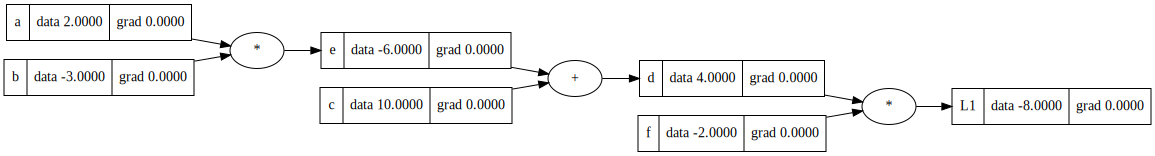

In [36]:
# add visualization to graph
import graphviz

def trace(root):
    nodes = set()
    edges = set()
    def _trace(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                _trace(child)
    _trace(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = graphviz.Digraph(format="svg", graph_attr={"rankdir":"LR"})
    for node in nodes:
        uid = str(id(node))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (node.label, node.data, node.grad), shape="record")
        if node._op:
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
    for src, dst in edges:
        dot.edge(str(id(src)), str(id(dst)) + dst._op)
    return dot

draw_dot(L)

Backpropagation

1) create a variable in Value class that contains derivative with respect to that value (self.grad = 0), grad = 0 means changing this variable does not change the loss function. Grad represents derivative with respect to the variable

Derivative of L with respect to L (i.e. you change by a tiny amount h, it changes by h. So derivative is 1)



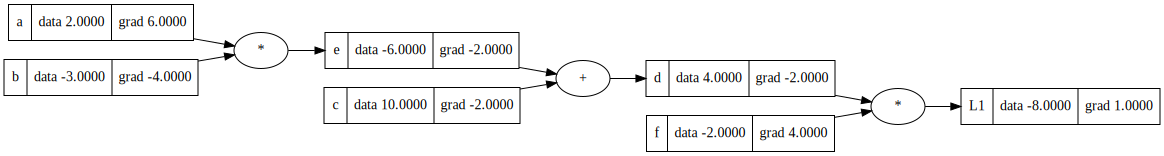

In [47]:
L.grad = 1.0

# dL/dd = ?
# def of derivative is: (f(x+h) - f(x))/ h
# function here is d*f
# ((d+h)*f - d*f) / h = df + hf - df / h = f
# derivative is f
d.grad = f.data

# symetrically dL/df = d
f.grad = d.data

# dL/dc
# how to derive?
# we know how L is sensitive to d
# but how is L impacted if c is wiggled
# intuitively, if you know the impact c has on d, and d has on L, you can put that info together
# dd / dc = ??
# d = c + e 
# dd / dc = 1
# go to basics
# (f(x+h) - f(x)) / h
# (c+h +e) - (c+e) / h = h/h = 1
# then, symetrically 
# dd / de = 1 as well
# this is the local derivative; the answer is the chain-rule in calculus
# the chain rule tells us how to chain the derivatives together
# we apply a multiplaction of the derivatives
# if a car travels twice as fast as a bicycle and the biccyle is four times as fast as the walking man, then the car travels 2x4 times as fast as the man

# dL / dc = (dL / dd) * (dd / dc), so you multiply the gradients
c.grad = d.grad * 1 # basically you just copy over the gradient when there is a plus node. Just routes the gradient
e.grad = d.grad * 1

# dL / da = dL/dd * dd/de * de/da
# then what is dc/da?
# f(x) = a*b
# (a+h)*b - a*b / h = b, so de/da = b
# symmetrically, de/db = a
a.grad = e.grad * b.data # dL/dd * dd/de * de/da
b.grad = e.grad * a.data # dL/dd * dd/de * de/db

# so in the multiplication case, you take the parent grad multiplied by the other child gradient and multiply them

draw_dot(L)

In [48]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')   
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c') 
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L1'
    L1 = L.data

    a = Value(2.0, label='a')   
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c') 
    e = a*b; e.label = 'e'
    # e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L2'
    L2 = L.data

    print ((L2-L1) / h)

lol()

-3.9999999999995595
